In [1]:
# this is to make the Jupyter notebook as wide as the screen (on the Mac at least) #
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format ='retina'


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import signal as sg
from datetime import datetime as dt
import xarray as xr

In [3]:
def prcrng(x):
    return (np.nanpercentile(x,84) - np.nanpercentile(x,16))/2.

In [4]:
dir_acs = "/users/rsg/spa/spapapers/Pardo_Globlal_Chla/insitu/reprocessing/netCDF/Graban2020/"
fn_acs = "NAB08.nc"

In [5]:
# read ACS (and HPLC) data in xr format
acs = xr.open_dataset(dir_acs + fn_acs)

# check keys
print(acs.keys())

#check attributes
acs['acs_chl'].attrs

# no of samples
print('No. of HPLC samples= ' + str(len(acs.hplc_time)))
print('No of ACS samples= ' + str(len(acs.time)))

KeysView(<xarray.Dataset>
Dimensions:         (time: 1089, hplc_time: 62, acs_wv: 176)
Coordinates:
  * time            (time) datetime64[ns] 2008-05-11T01:14:01 ... 2008-05-21T...
  * hplc_time       (hplc_time) datetime64[ns] 2008-05-03T11:28:00 ... 2008-0...
  * acs_wv          (acs_wv) float64 400.0 402.0 404.0 ... 746.0 748.0 750.0
Data variables:
    hplc_lat        (hplc_time) float64 ...
    hplc_lon        (hplc_time) float64 ...
    hplc_Tot_Chl_a  (hplc_time) float64 ...
    uway_lat        (time) float64 ...
    uway_lon        (time) float64 ...
    acs_chl         (time) float64 ...
    acs_ap          (time, acs_wv) float64 ...)
No. of HPLC samples= 62
No of ACS samples= 1089


['2008-05-11T01:14:01.000000000' '2008-05-11T01:24:01.000000000'
 '2008-05-11T01:34:01.000000000' ... '2008-05-21T08:34:01.000000000'
 '2008-05-21T08:44:01.000000000' '2008-05-21T08:54:01.000000000']


Text(0, 0.5, 'lon')

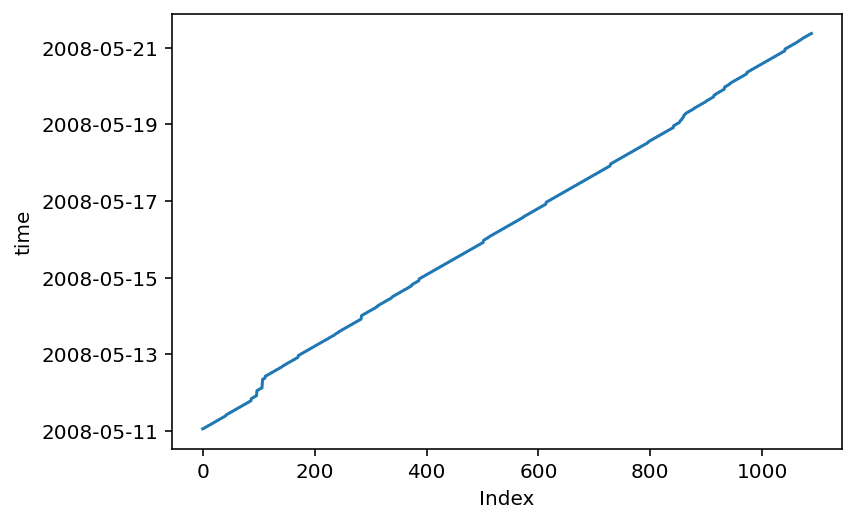

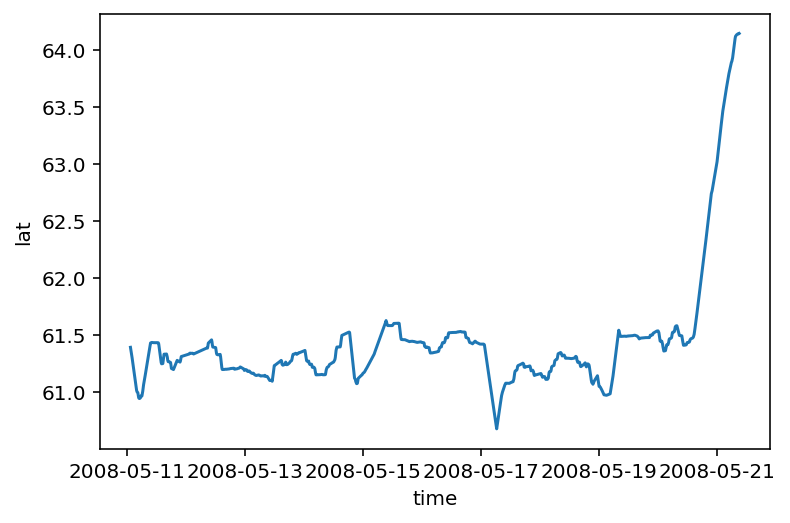

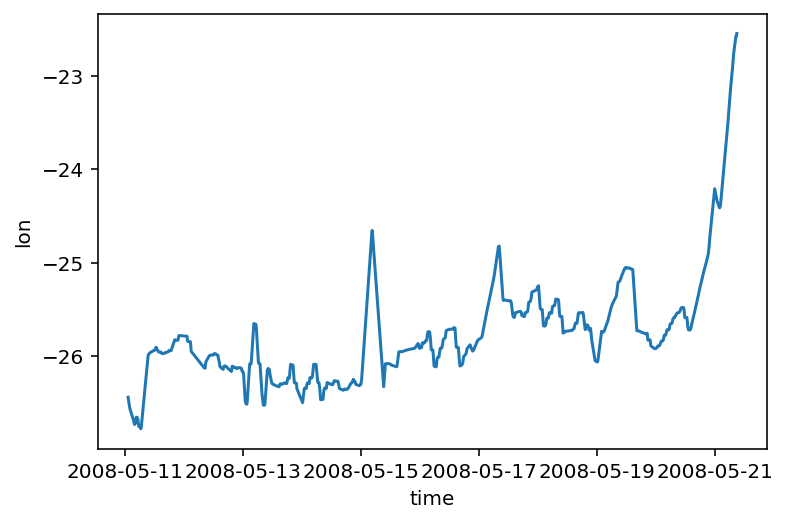

In [6]:
# check time, lat, lon
plt.rcParams.update({'font.size': 9})
    
plt.figure()
plt.plot(acs.time)
plt.xlabel('Index')
plt.ylabel('time')
print(acs.time.values)

plt.figure()
plt.plot(acs.time, acs.uway_lat)
plt.xlabel('time')
plt.ylabel('lat')

plt.figure()
plt.plot(acs.time, acs.uway_lon)
plt.xlabel('time')
plt.ylabel('lon')

# repeat time indicies are present - must remove

['2008-05-11T01:14:01.000000000' '2008-05-11T01:24:01.000000000'
 '2008-05-11T01:34:01.000000000' ... '2008-05-21T08:34:01.000000000'
 '2008-05-21T08:44:01.000000000' '2008-05-21T08:54:01.000000000']


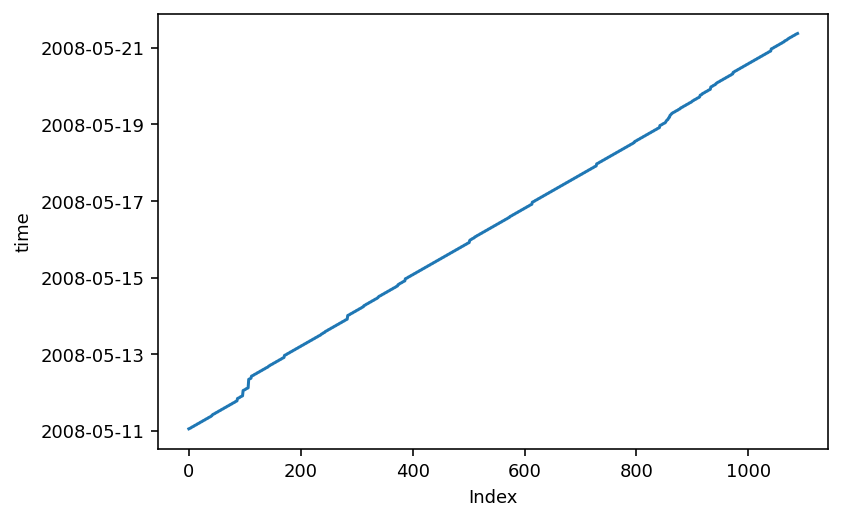

In [7]:
_, index = np.unique(acs['time'], return_index=True)
acs = acs.isel(time=index)
 
# check time, lat, lon
plt.rcParams.update({'font.size': 9})
    
plt.figure()
plt.plot(acs.time)
plt.xlabel('Index')
plt.ylabel('time')
print(acs.time.values)



In [8]:
# check temporal sample rate
plt.figure()
delta_t = np.median(np.diff(acs.time))
print(delta_t)
print(str(int(delta_t/10**9)) + ' secs')

# == 10 min sample rate 

600000000000 nanoseconds
600 secs


<Figure size 432x288 with 0 Axes>

['hplc_lat', 'hplc_lon', 'hplc_Tot_Chl_a', 'uway_lat', 'uway_lon', 'acs_chl', 'acs_ap']


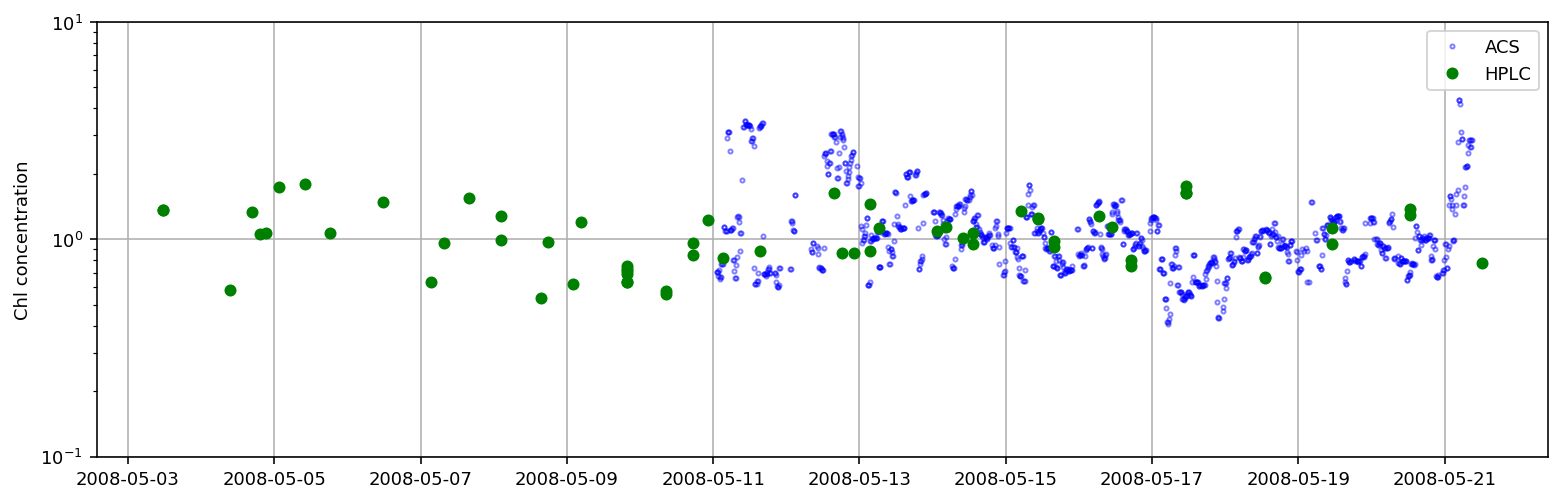

In [9]:
# Test plot of ACS(9) and HPLC Chl prior to match-up
# include emprical adjustment of AC9 chl using AMT
MEDFILT_WIN = 3 # window length of med filter in minutes - note: this assumes data has been binned at 1 minute

#
fig2, ax2 = plt.subplots(1, figsize=(13, 4))
ax2.semilogy(acs.time, sg.medfilt(acs.acs_chl, kernel_size=MEDFILT_WIN), 'bo', lw=1, ms=2, mfc='none', alpha = 0.5, label='ACS')
ax2.grid('on')
plt.legend()
plt.ylim([1e-1, 10])
plt.ylabel('Chl concentration')

#
print(list(acs.keys()))
ax2.semilogy(acs.hplc_time, acs.hplc_Tot_Chl_a, 'go', ms=5, alpha=1, label='HPLC')#, mfc='none')
# a2.semilogy(df_CTD.index, df_CTD.Tot_Chl_a, 'ko', ms=7, alpha=1, mfc='none', zorder=60)
# ax2.scatter(df_CTD.index, df_CTD.Tot_Chl_a, c=df_CTD.Bottle.values, s=30, alpha=1, zorder=60, cmap = plt.get_cmap('inferno'), vmin=2, vmax=24)
# ax2.semilogy(df_UND.index, df_UND.Tot_Chl_a, 'ks', ms=7, alpha=0.85, mfc='c')
plt.legend()
#########


1089
1089


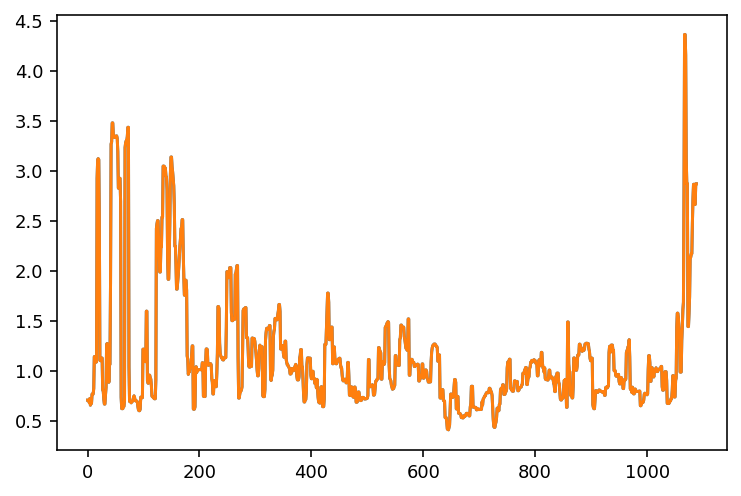

In [10]:
# step x - # median filter
plt.figure()
acs['acs_chl'].values = sg.medfilt(acs.acs_chl, kernel_size = MEDFILT_WIN) # apply med filter to acx chl and acx chl debiasesd 
plt.plot(acs['acs_chl'].values)

# step y  #filters w.r.t. ap(420) (10th element) being > 0
i2kp = np.where((acs.acs_ap[:,10] > 0)) [0]
iy = xr.DataArray(acs.time[i2kp], dims=['time']) 
acs_y = acs.sel(time = iy)
plt.plot(acs_y['acs_chl'].values)
print(len(acs_y['acs_chl'].values))

#step z - # filters w.r.t. acs chl being > 0
i2kp = np.where((acs_y.acs_chl[:] > 0)) [0]
iz = xr.DataArray(acs_y.time[i2kp], dims=['time']) 
acs_z = acs_y.sel(time = iz)
print(len(acs_z['acs_chl'].values))

# for NAAMES 2 - data looks to have already had effective QC


In [11]:
acs = []
acs = acs_z # redefine as filtered data structure

In [12]:
# match-ups #
# filter replicate hplcs
# match-ups #
# create serier objects
df_hplc = pd.Series(acs['hplc_Tot_Chl_a'].values ,index = acs.hplc_time)
df_acs = pd.Series(acs['acs_chl'].values, index = acs.time)

# filter
df_hplc = df_hplc.groupby(df_hplc.index).mean() 
df_acs = df_acs.groupby(df_acs.index).mean() 

df_hplc_acs = pd.DataFrame({'Tot_Chl_a': df_hplc, 'acs_chl': df_acs})
#df_hplc_acs = df_hplc_acs.interpolate('index',limit=1).reindex(df_hplc_acs.index,method='nearest',tolerance='30min')
df_hplc_acs = df_hplc_acs.interpolate('index').reindex(df_hplc.index,method='nearest',tolerance='30min') 


In [14]:
print(df_hplc)

print(df_acs)

print(df_hplc_acs)
# nans in acs_ch are where there are no match-ups

2008-05-03 11:28:00    1.357500
2008-05-04 09:23:00    0.586000
2008-05-04 16:44:00    1.333000
2008-05-04 19:13:00    1.058000
2008-05-04 21:24:00    1.071000
2008-05-05 01:30:00    1.730000
2008-05-05 10:07:00    1.785000
2008-05-05 18:18:00    1.071000
2008-05-06 11:46:00    1.475000
2008-05-07 03:17:00    0.633000
2008-05-07 07:35:00    0.956000
2008-05-07 15:46:00    1.540000
2008-05-08 02:26:00    1.133500
2008-05-08 15:34:00    0.535000
2008-05-08 17:57:00    0.969000
2008-05-09 01:55:00    0.620000
2008-05-09 04:45:00    1.196000
2008-05-09 19:48:00    0.692167
2008-05-10 08:41:00    0.568000
2008-05-10 17:33:00    0.903000
2008-05-10 22:19:00    1.226000
2008-05-11 03:15:00    0.819000
2008-05-11 15:15:00    0.884000
2008-05-12 15:48:00    1.622000
2008-05-12 18:18:00    0.865000
2008-05-12 22:22:00    0.867000
2008-05-13 03:22:00    1.167000
2008-05-13 06:21:00    1.120000
2008-05-14 01:26:00    1.092000
2008-05-14 04:34:00    1.140000
2008-05-14 10:01:00    1.011000
2008-05-

In [23]:
# compute residuals (lin and log space)
rres = df_hplc_acs.acs_chl.values / df_hplc_acs.Tot_Chl_a.values - 1
rres_log = np.log10(df_hplc_acs.acs_chl.values)/ np.log10(df_hplc_acs.Tot_Chl_a.values) - 1
rres_log_diff =(np.log(df_hplc_acs.acs_chl.values) - np.log(df_hplc_acs.Tot_Chl_a.values))
# this approximates rres for small  differences - multiply by = (1/np.log10(np.exp(1))) to convert to log 10


delta = np.nanmedian(rres)
delta_log = np.nanmedian(rres_log)
delta_log_diff = np.nanmedian(rres_log_diff)

sigma = prcrng(rres)
sigma_log = prcrng(rres_log)
sigma_log_diff = prcrng(rres_log_diff)
                   
N = np.sum(~np.isnan(rres))
N_log = np.sum(~np.isnan(rres_log))

print('Linear metrics')
print(delta, sigma, N)

print('Log metrics')
print(delta_log, sigma_log, N)

                   
print('Log diff metrics (should approximate linear)' )
print(delta_log_diff, sigma_log_diff, N)




Linear metrics
0.13090802102725296 0.8893057356279765 22
Log metrics
-1.0374790386368045 3.2911566416119795 22
Log diff metrics (should approximate linear)
0.12284361402910701 0.6571851601904735 22


['hplc_lat', 'hplc_lon', 'hplc_Tot_Chl_a', 'uway_lat', 'uway_lon', 'acs_chl', 'acs_ap']


/tmp/ipykernel_8918/3930132883.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  ax2.semilogy(df_hplc.index, df_hplc.values, 'go', ms=5, color='green', alpha=1, label='HPLC_all')#, mfc='none')
/tmp/ipykernel_8918/3930132883.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  ax2.semilogy(df_hplc_acs.index[~np.isnan(rres)==1], df_hplc_acs.Tot_Chl_a[~np.isnan(rres)==1], 'go', ms=5, color='red', alpha=1, label='HPLC matches')#, mfc='none')


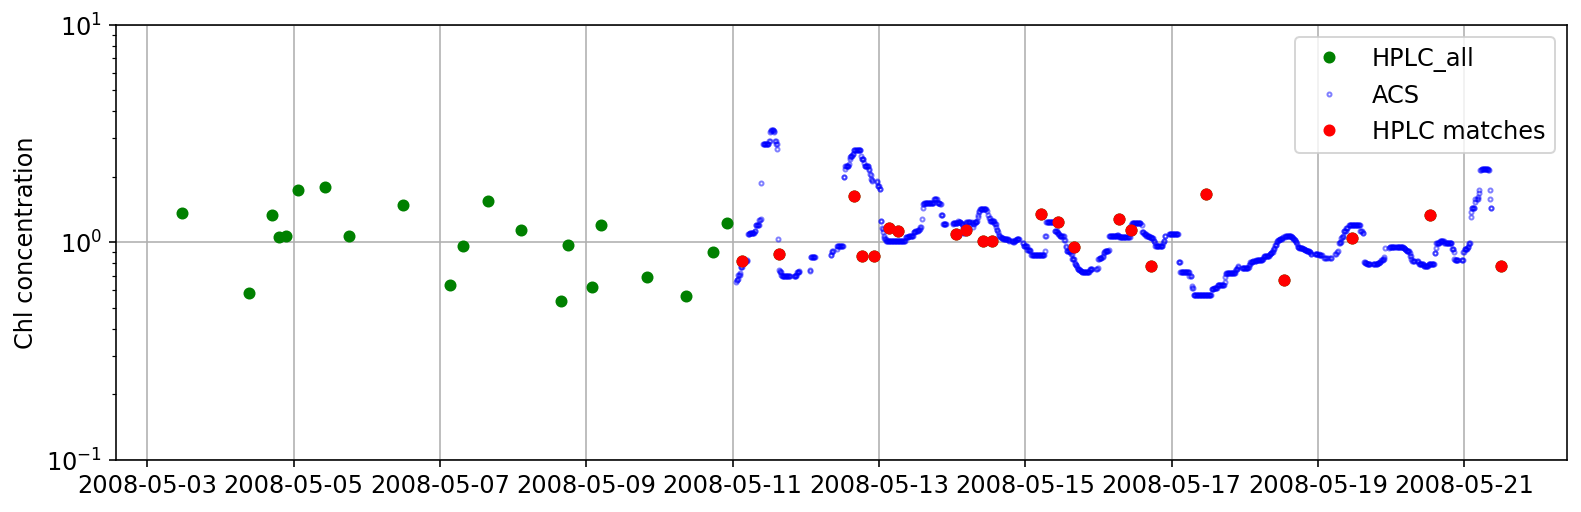

In [24]:
# Test plot of ACS(9) and HPLC Chl post match-up


MEDFILT_WIN = 31 # window length of med filter in minutes - note: this assumes data has been binned at 1 minute. 

#
fig2, ax2 = plt.subplots(1, figsize=(13, 4))
ax2.semilogy(df_hplc.index, df_hplc.values, 'go', ms=5, color='green', alpha=1, label='HPLC_all')#, mfc='none')
ax2.semilogy(acs.time, sg.medfilt(acs.acs_chl, kernel_size=MEDFILT_WIN), 'bo', lw=1, ms=2, mfc='none', alpha = 0.5, label='ACS')
ax2.grid('on')
plt.legend()
plt.ylim([1e-1, 10])
plt.ylabel('Chl concentration')

print(list(acs.keys()))
ax2.semilogy(df_hplc_acs.index[~np.isnan(rres)==1], df_hplc_acs.Tot_Chl_a[~np.isnan(rres)==1], 'go', ms=5, color='red', alpha=1, label='HPLC matches')#, mfc='none')
plt.legend()
#########




[1.3575     0.586      1.333      1.058      1.071      1.73
 1.785      1.071      1.475      0.633      0.956      1.54
 1.1335     0.535      0.969      0.62       1.196      0.69216667
 0.568      0.903      1.226      0.819      0.884      1.622
 0.865      0.867      1.167      1.12       1.092      1.14
 1.011      1.0105     1.343      1.242      0.9465     1.276
 1.14       0.779      1.67033333 0.6665     1.0405     1.3315
 0.776     ]


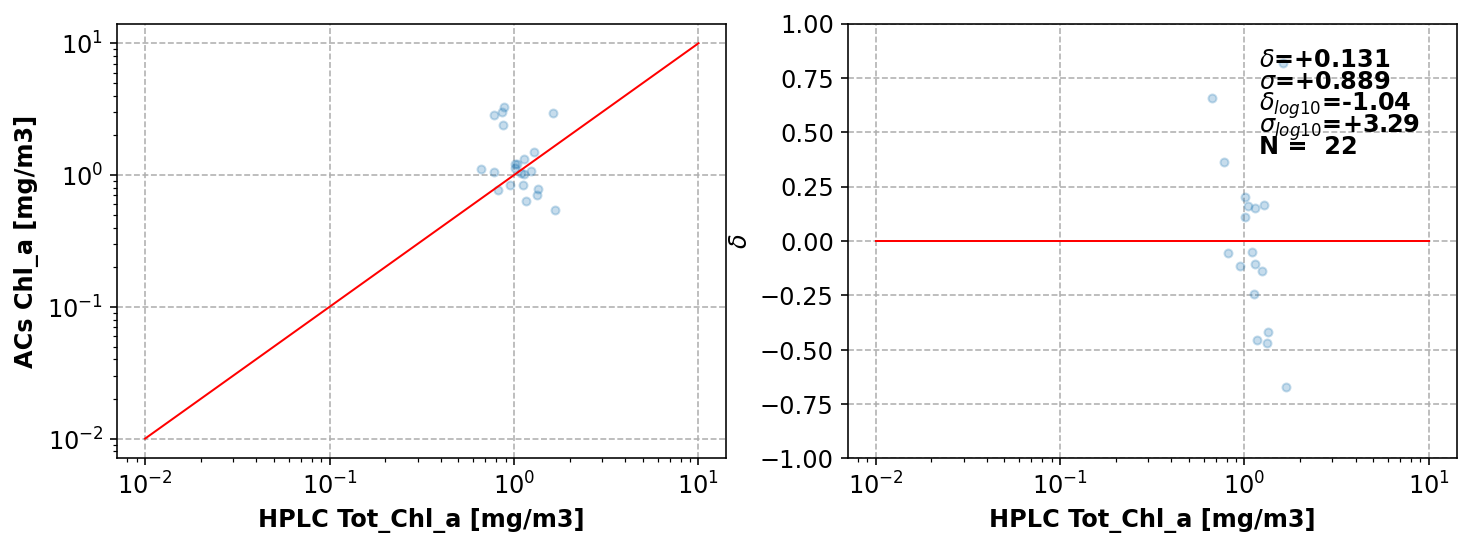

In [25]:
# scatter plots
plt.rcParams.update({'font.size': 12})
    
fig, ax = plt.subplots(1,2, figsize=(12, 4))

ax[0].loglog(df_hplc_acs.Tot_Chl_a.values, df_hplc_acs.acs_chl.values, 'o', ms=4, alpha=0.25)
x = np.logspace(np.log10(0.01), np.log10(10), 100)
ax[0].loglog(x, x, 'r-', lw=1)
ax[0].grid('on', ls='--')
ax[0].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[0].set_ylabel('ACs Chl_a [mg/m3]', fontweight='bold')

ax[1].semilogx(df_hplc_acs.Tot_Chl_a.values, rres, 'o', ms=4, alpha=0.25)
ax[1].semilogx(x, x*0, 'r-', lw=1)
ax[1].grid('on', ls='--')
ax[1].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[1].set_ylabel('$\delta$', fontweight='bold')
ax[1].set_ylim([-1, 1])
ax[1].text(1.2, 0.8, r'$\delta$='+f'{delta:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.7, r'$\sigma$='+f'{sigma:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.6, r'$\delta_{log10}$='+f'{delta_log:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.5, r'$\sigma_{log10}$='+f'{sigma_log:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.4, f'N = {N: 0}', fontweight='bold')




print(df_hplc_acs.Tot_Chl_a.values)



(-1.0, 1.0)

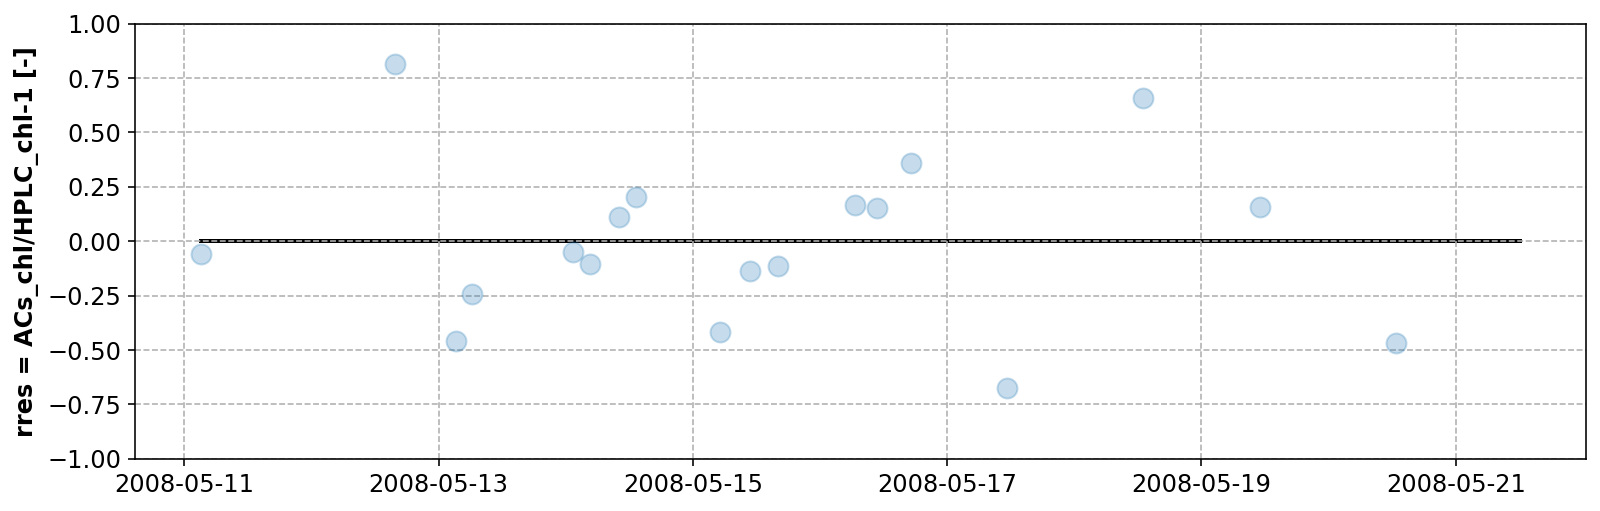

In [26]:
fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.semilogx(df_hplc_acs.index.values, rres, 'o', ms=10, alpha=0.25, zorder=60)
ax.plot(df_hplc_acs.index.values, rres*0, 'k-', lw=2, zorder=1)
ax.set_ylabel('rres = ACs_chl/HPLC_chl-1 [-]', fontweight='bold')
ax.grid('on', ls='--')
ax.set_ylim([-1, 1])

In [27]:
# Apply log transform prior to fitting power-law. Notation follows Brewin 2016. 
import scipy

linear_mod = scipy.stats.linregress(np.log10(0.014*df_hplc_acs.acs_chl.values[~np.isnan(rres)==1]), np.log10(df_hplc_acs.Tot_Chl_a.values[~np.isnan(rres)==1]))

A = np.round(100*linear_mod.intercept)/100
B = np.round(1000*linear_mod.slope)/1000
r_sq = np.round(1000*linear_mod.rvalue**2)/100

r_sq = np.round(1000*linear_mod.rvalue**2)/1000
stderr = np.round(1000*linear_mod.stderr)/1000
interr = np.round(1000*linear_mod.intercept_stderr)/1000

print('A = ' + str(10**A) + ' +/- ' + str(2*10**interr))
print('B = ' + str(B) + ' +/- ' + str(2*stderr))
print('r_sq = ' + str(r_sq))

A = 0.6025595860743578 +/- 2.951413066551789
B = -0.136 +/- 0.19
r_sq = 0.093


In [28]:
# de-bias ACS-chl following eq 3 in Graban et al., 2020 (https://doi.org/10.1364/OE.397863)
acs['acs_chl_debiased'] = acs.acs_chl*(1-delta)
# acs_out = pd.DataFrame(data = {'lat [degN]': acs.uway_lat[i2f][innan],
#                              'lon [degE]': acs.uway_lon[i2f][innan],
#                             'acs_chl_debiased [mg_m3]': acs.acs_chl_debiased[i2f][innan]
#                           }  ,
# index = acs.time.values[i2f][innan])

In [29]:
# add attributes to acs_chl_debiased #
acs.acs_chl_debiased.attrs["debiasing_equation"] = "acs.acs_chl_debiased = acs.acs_chl*(1-delta)"
acs.acs_chl_debiased.attrs["delta"] = delta
acs.acs_chl_debiased.attrs["sigma"] = sigma
acs.acs_chl_debiased.attrs["units"] = "mg/m3"
acs.acs_chl_debiased.attrs["comments"] = "delta=np.nanmedian(rres), sigma=prcrng(rres), rres=acs_chl/HPLC_Tot_Chl_a-1, based on surface data"
acs.acs_chl_debiased.attrs["HPLC_Tot_chla"] = df_hplc_acs.Tot_Chl_a[~np.isnan(rres)==1].values  # filter nans
acs.acs_chl_debiased.attrs["HPLC_Tot_chla_units"] = "mg/m3"
acs.acs_chl_debiased.attrs["acs_chl"] = df_hplc_acs[~np.isnan(rres)==1].acs_chl.values # filter nans
acs.acs_chl_debiased.attrs["acs_chl_units"] = "mg/m3"
acs.acs_chl_debiased.attrs["processed_on"] = dt.now().strftime("%Y-%m-%d %H:%M:%S.%f")
acs.acs_chl_debiased.attrs["match_up_dates"] = df_hplc_acs[~np.isnan(rres)==1].index.format()

In [30]:

print(acs.acs_chl_debiased)
len(acs.acs_chl_debiased.attrs["match_up_dates"])
len(acs.acs_chl_debiased.attrs["HPLC_Tot_chla"])


<xarray.DataArray 'acs_chl_debiased' (time: 1089)>
array([0.61297889, 0.61297889, 0.61297889, ..., 2.31633705, 2.49679783,
       2.49679783])
Coordinates:
  * time     (time) datetime64[ns] 2008-05-11T01:14:01 ... 2008-05-21T08:54:01
Attributes:
    debiasing_equation:   acs.acs_chl_debiased = acs.acs_chl*(1-delta)
    delta:                0.13090802102725296
    sigma:                0.8893057356279765
    units:                mg/m3
    comments:             delta=np.nanmedian(rres), sigma=prcrng(rres), rres=...
    HPLC_Tot_chla:        [0.819      0.884      1.622      0.865      0.867 ...
    HPLC_Tot_chla_units:  mg/m3
    acs_chl:              [0.77193717 3.28570581 2.94716074 3.02327534 2.3950...
    acs_chl_units:        mg/m3
    processed_on:         2023-12-04 09:53:34.527572
    match_up_dates:       ['2008-05-11 03:15:00', '2008-05-11 15:15:00', '200...


22

In [31]:
print('max/min conc range for results table')
print(np.min(acs.acs_chl_debiased.attrs["HPLC_Tot_chla"]))
print(np.max(acs.acs_chl_debiased.attrs["HPLC_Tot_chla"])) # quote min max of match-ups 

max/min conc range for results table
0.6665000000000001
1.6703333333333334


In [32]:

# save updated NetCDF file
dir_acs_out = '/data/datasets/cruise_data/active/ACS_Chl/Glob_OC_matchups/Debiased_nc/'
acs.to_netcdf(dir_acs_out + fn_acs[:-3] + '_with_debiased_chl.nc')
acs.close()
